In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset
import sys
import matplotlib.pyplot as plt
from IPython import display

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Resize(64),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=transform)

In [4]:
print(dataset.classes)
classes_keep = [ 'Trouser','Sneaker','Pullover' ]

images_use = torch.Tensor()
for i in range(len(classes_keep)):
  classidx = dataset.classes.index(classes_keep[i])
  images_use = torch.cat( (images_use,torch.where(dataset.targets==classidx)[0]), 0).type(torch.long)
  print(f'Added class {classes_keep[i]} (index {classidx})')

batch_size = 128
sampler = torch.utils.data.sampler.SubsetRandomSampler(images_use)
data_loader = DataLoader(dataset,sampler=sampler,batch_size=batch_size,drop_last=True)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Added class Trouser (index 1)
Added class Sneaker (index 7)
Added class Pullover (index 2)


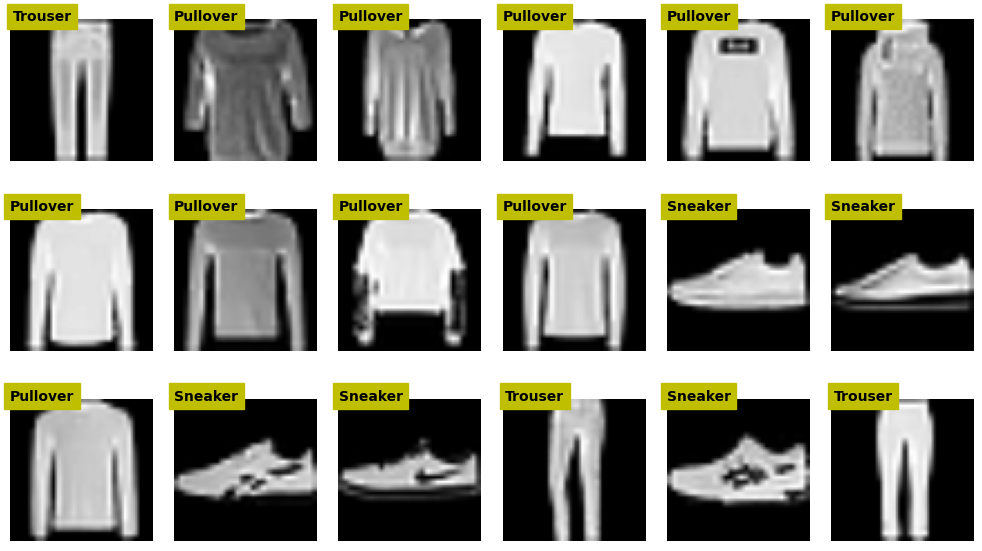

In [5]:
X,y = next(iter(data_loader))
fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):
  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5 # undo normalization
  
  label = dataset.classes[y[i]]

  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
class DModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1,64,4,2,1)
        self.conv2 = nn.Conv2d(64,128,4,2,1)
        self.conv3 = nn.Conv2d(128,256,4,2,1)
        self.conv4 = nn.Conv2d(256,512,4,2,1)
        self.conv5 = nn.Conv2d(512,1,4,1,0)

        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.conv5(x)
        x = torch.sigmoid(x)
        return x.view(-1,1)

In [7]:
d_model = DModel()
y = d_model(torch.rand(2,1,64,64))
y.shape

torch.Size([2, 1])

torch.Size([2, 1, 64, 64])


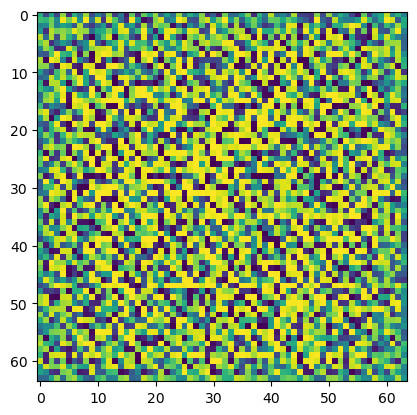

In [8]:
class GModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.ConvTranspose2d(100,512,4,1,0)
        self.conv2 = nn.ConvTranspose2d(512,256,4,2,1)
        self.conv3 = nn.ConvTranspose2d(256,128,4,2,1)
        self.conv4 = nn.ConvTranspose2d(128,64,4,2,1)
        self.conv5 = nn.ConvTranspose2d(64,1,4,2,1)

        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)

    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = torch.tanh(self.conv5(x))
        return x
    
g_model = GModel()
y = g_model(torch.randn(2,100,1,1))
print(y.shape)
plt.imshow(y[0].squeeze().detach().numpy())


In [9]:
loss_fun = nn.BCELoss()
d_model = d_model.to(device)
g_model = g_model.to(device)

d_optimizer = torch.optim.Adam(d_model.parameters(), lr=.0002)
g_optimizer = torch.optim.Adam(g_model.parameters(), lr=.0002)

In [10]:
EPOCHS = int(50_000/len(data_loader))

losses = []
results_decision = []

for i in range(EPOCHS):
    
    for data, _ in data_loader:

        data = data.to(device)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        pred_real = d_model(data)
        d_loss_real = loss_fun(pred_real, real_labels)

        fake_data = torch.randn(batch_size,100,1,1).to(device)
        fake_images = g_model(fake_data)
        pred_fake = d_model(fake_images)
        d_loss_fake = loss_fun(pred_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        fake_images = g_model(torch.randn(batch_size,100,1,1).to(device))
        pred_fake = d_model(fake_images)

        g_loss = loss_fun(pred_fake, real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        losses.append([d_loss.item(), g_loss.item()])

        d1 = torch.mean((pred_real>.5).float()).detach().cpu()
        d2 = torch.mean((pred_real>.5).float()).detach().cpu()
        results_decision.append([d1,d2])

    print(f"Epoch {i+1} of {EPOCHS} | d_loss : {d_loss:.4f} | g_loss : {g_loss:.4f}")

losses = np.array(losses)
results_decision = np.array(results_decision)

Epoch 1 of 357 | d_loss : 0.0008 | g_loss : 8.1468
Epoch 2 of 357 | d_loss : 0.0286 | g_loss : 6.5132
Epoch 3 of 357 | d_loss : 0.1065 | g_loss : 5.2714
Epoch 4 of 357 | d_loss : 0.0489 | g_loss : 6.3662
Epoch 5 of 357 | d_loss : 0.1573 | g_loss : 3.7173
Epoch 6 of 357 | d_loss : 0.0853 | g_loss : 8.7782
Epoch 7 of 357 | d_loss : 0.0988 | g_loss : 4.0935
Epoch 8 of 357 | d_loss : 0.0333 | g_loss : 7.1371
Epoch 9 of 357 | d_loss : 0.1428 | g_loss : 3.3759
Epoch 10 of 357 | d_loss : 0.0423 | g_loss : 3.3088
Epoch 11 of 357 | d_loss : 0.0133 | g_loss : 4.6997
Epoch 12 of 357 | d_loss : 0.1193 | g_loss : 6.3406
Epoch 13 of 357 | d_loss : 0.6025 | g_loss : 3.3803
Epoch 14 of 357 | d_loss : 0.0469 | g_loss : 5.8406
Epoch 15 of 357 | d_loss : 0.0236 | g_loss : 6.4033
Epoch 16 of 357 | d_loss : 0.0099 | g_loss : 7.8316
Epoch 17 of 357 | d_loss : 0.1112 | g_loss : 6.7499
Epoch 18 of 357 | d_loss : 0.2754 | g_loss : 5.1574
Epoch 19 of 357 | d_loss : 0.0232 | g_loss : 7.4632
Epoch 20 of 357 | d_l

In [11]:
# create a 1D smoothing filter
def smooth(x,k=10):
  return np.convolve(x,np.ones(k)/k,mode='same')

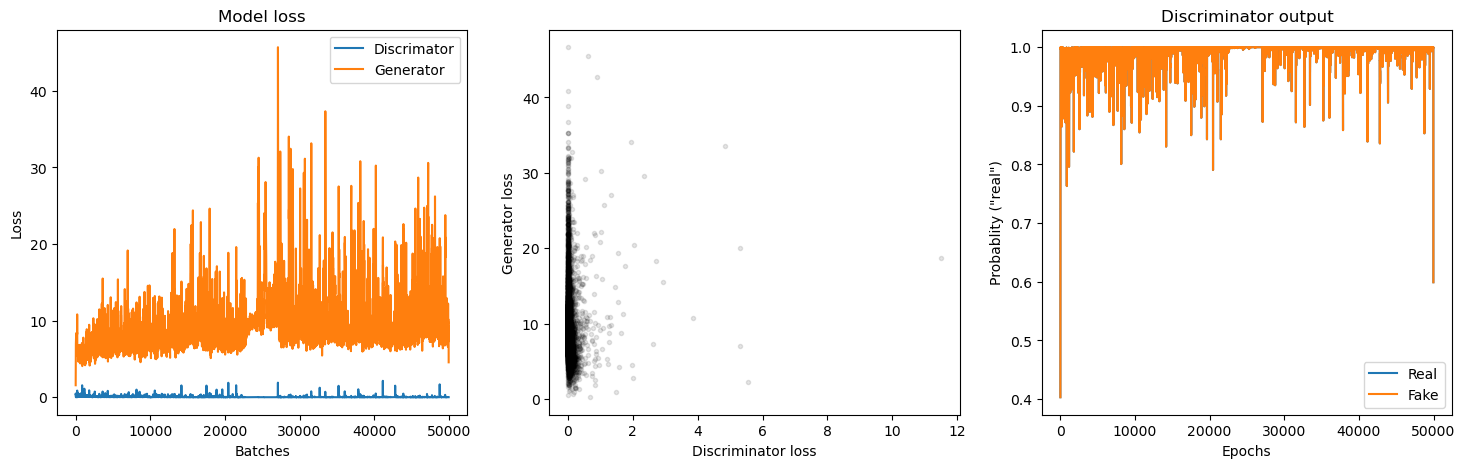

In [12]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(results_decision[:,0]))
ax[2].plot(smooth(results_decision[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

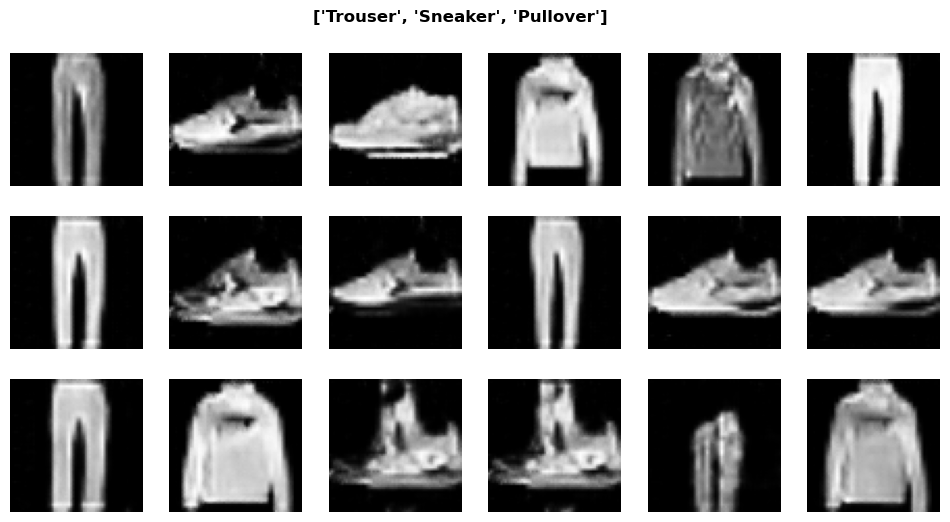

In [13]:
# generate the images from the generator network
g_model.eval()
fake_data = g_model( torch.randn(batch_size,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().squeeze(),cmap='gray')
  ax.axis('off')

plt.suptitle(classes_keep,y=.95,fontweight='bold')
plt.show()